# Prediction+RenderQueue
In diesem Notebook wird mit den erzeugten Modellen gearbeitet und entweder einzelne bilder oder ganze Queues Bearbeitet!


# Predict Images Setup

In [1]:
#Imports
import os
import cv2
import numpy as np
from numpy.random import randint
from tqdm import tqdm
import matplotlib.pyplot as plt

from keras import Model
from keras.models import load_model
import keras.backend as K

## Configuration

In [2]:
#Model Config
modelname='Model_atEpoch_2'

#Single IMG Prediction Config
LR_IMGPATH="ULR_Pic\\ULR_00000.png"
HR_IMGPATH = "HR_Pic\\HR_00000.png"


#Render Queue Config
INPUT = "Input\\"
PREDICTION = "Prediction\\"


## Load Model

In [3]:
generator = load_model(str(modelname+'.h5'), compile=False)

## Initialise Model with right shape

In [5]:

hr_image =cv2.imread(HR_IMGPATH,flags= cv2.IMREAD_COLOR)
hr_image = cv2.cvtColor(hr_image, cv2.COLOR_BGR2RGB)

def extract_pixel_sample(image, x, y, size=128):
    sample = image[y:y+size, x:x+size]
    return sample
initializesample =[]

initializesample.append(extract_pixel_sample(hr_image,0,0,size=32))
initializesample = np.array(initializesample)
initializesample = initializesample/255.0
initializesample = np.reshape(initializesample,(-1,32,32,3))

initprediction = generator.predict(initializesample)

1/1 [==============================] - 0s 153ms/step


## Define Score Functions

In [6]:
# PSNR Function and !SSIM Function!
def PSNR(y_true, y_pred):
    max_pixel = 1.0
    return (10.0 * K.log((max_pixel ** 2) / (K.mean(K.square(y_pred - y_true), axis=-1)))) / 2.303

# Predict Single Image

1/1 [==============================] - 15s 15s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[[[23.97362698 23.37939368 23.41903334 ... 27.73109896 24.84612742
   26.4996654 ]
  [24.04252813 23.37327117 23.44545292 ... 26.05756055 29.41396886
   34.18647405]
  [24.01650211 23.21426548 23.3686154  ... 26.15387436 25.66347959
   29.12771055]
  ...
  [27.08693042 27.08104929 27.36248336 ... 26.83480371 26.37248083
   27.45355117]
  [30.24200585 30.44133948 31.00193226 ... 28.66856781 28.14048667
   28.49162641]
  [30.42922948 30.78598399 31.07990103 ... 28.48037316 28.10517452
   28.24821661]]], shape=(1, 1080, 1920), dtype=float64)


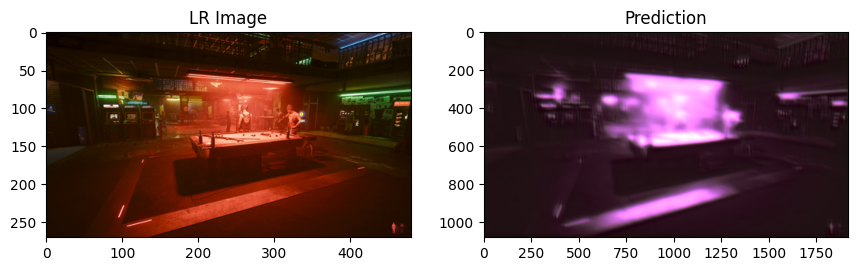

In [7]:
lr_image = cv2.imread(LR_IMGPATH,flags= cv2.IMREAD_COLOR)
lr_image = cv2.cvtColor(lr_image, cv2.COLOR_BGR2RGB)
hr_image =cv2.imread(HR_IMGPATH,flags= cv2.IMREAD_COLOR)
hr_image = cv2.cvtColor(hr_image, cv2.COLOR_BGR2RGB)

lr_image = lr_image / 255.0
hr_image = hr_image / 255.0

lr_image = np.expand_dims(lr_image, axis=0)
generated_sreeni_hr = generator.predict(lr_image)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(lr_image[0,:,:,:])
plt.subplot(232)
plt.title('Prediction')
plt.imshow(generated_sreeni_hr[0,:,:,:])

#save plot for Comparison
plt.savefig(str(modelname+".jpg"),bbox_inches ='tight')

print(PSNR(hr_image,generated_sreeni_hr))
plt.show()

# Render Queue

In [ ]:
def predict_X(input_datei, output_datei):

    lr = cv2.imread(input_datei,flags= cv2.IMREAD_COLOR)
    lr = cv2.cvtColor(lr, cv2.COLOR_BGR2RGB)
    lr = lr / 255.
    lr = np.expand_dims(lr, axis=0)

    generated__hr = generator.predict(lr)


    generated__hr[0,:,:,:] = cv2.imwrite(output_datei,cv2.cvtColor(generated__hr[0,:,:,:]*255,cv2.COLOR_RGB2BGR))


for img in tqdm(os.listdir(INPUT)):
    predict_X(str(INPUT+img) , str(PREDICTION+"HR"+img[3:]))#Change nuber in [] for length of name till number or seperator. Example "ULR_0000" =>[3:] =>"_0000"